### Importação de Pacotes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt,het_white
from statsmodels.compat import lzip
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pingouin as pg
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf

### Importação dos Dados


In [2]:
#Caminho do arquivo
path = '/media/matheus/HD/UFPR/2021/2º Semestre 2021/Estatística Econômica e Introdução à Econometria/1. Relatório Enade/2018/3.DADOS/microdados_enade_2018.txt'

In [3]:
enade = pd.read_csv(path, sep=';', encoding='latin-1', header=0) #importação

/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
enade.shape #dimensões da base de dados

(548127, 137)

### Tratamento da base

In [5]:
enade.head()

,NU_ANO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_CURSO,CO_MODALIDADE,CO_MUNIC_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO,...,QE_I59,QE_I60,QE_I61,QE_I62,QE_I63,QE_I64,QE_I65,QE_I66,QE_I67,QE_I68
0,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0
1,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
2,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0
3,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6.0,6.0,6.0,6.0,5.0,6.0,6.0,6.0,6.0,4.0
4,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0


In [6]:
economia = enade[enade['CO_GRUPO']==13] #seleciona os dados do curso de economia
economia = economia[economia['NT_GER'].notna()] #seleciona os dados que não são nulos
economia['NT_GER'] = economia['NT_GER'].replace(',', '.', regex=True) #substitui a vírgula por ponto
economia['NT_GER'] = pd.to_numeric(economia['NT_GER']) #converte os dados para números

In [7]:
#Filtra base para varíaveis selecionadas 
economia_var = economia.filter(['NT_GER','QE_I04', 'QE_I05','QE_I10','QE_I17','QE_I23'])
#Variáveis
#Nota geral: NT_GER
#Ensino Médio: QE_I17 
#Tempo disponível(horas trabalhadas): QE_I10
#tempo de estudo (extra classe): - QE_I23
#escolaridade dos pais(tem nível superior?): QE_I04 - Pai, QE_I05 - Mãe


In [8]:
#Renomeia as colunas
economia_var.columns = ['Nota Geral', 'Escolaridade Pai','Escolaridade Mãe', 'Horas de Trabalho','Ensino Médio','Tempo de Estudo']

In [9]:
dict_nova_resposta_escolaridade = {
    'A':0,
    'B':0,
    'C':0,
    'D':0, 
    'E':1,
    'F':1}

dict_nova_resposta_EM = {
    'A':0,
    'B':1,
    'C':1,
    'D':0, 
    'E':1,
    'F':1}

dict_nova_resposta_estudo = {
    'A':0,
    'B':1,
    'C':2,
    'D':3, 
    'E':4}

dict_nova_resposta_trabalho = {
    'A':0,
    'B':1,
    'C':2,
    'D':3, 
    'E':4}



In [10]:
#Substitui os valores de escolaridade por respostas
economia_var['Escolaridade Pai'] = economia_var['Escolaridade Pai'].map(dict_nova_resposta_escolaridade)
economia_var['Escolaridade Mãe'] = economia_var['Escolaridade Mãe'].map(dict_nova_resposta_escolaridade)
economia_var['Ensino Médio'] = economia_var['Ensino Médio'].map(dict_nova_resposta_EM)
economia_var['Tempo de Estudo'] = economia_var['Tempo de Estudo'].map(dict_nova_resposta_estudo)
economia_var['Horas de Trabalho'] = economia_var['Horas de Trabalho'].map(dict_nova_resposta_trabalho)

In [11]:
economia_var = economia_var[(economia_var['Ensino Médio']!='C')&(economia_var['Ensino Médio']!='F')]

In [12]:
dummies = pd.get_dummies(economia_var, 
    columns=[
        'Escolaridade Pai',
        'Escolaridade Mãe',
        'Tempo de Estudo',
        'Horas de Trabalho',
        'Ensino Médio'
        ])

In [13]:
dummies

,Nota Geral,Escolaridade Pai_0.0,Escolaridade Pai_1.0,Escolaridade Mãe_0.0,Escolaridade Mãe_1.0,Tempo de Estudo_0.0,Tempo de Estudo_1.0,Tempo de Estudo_2.0,Tempo de Estudo_3.0,Tempo de Estudo_4.0,Horas de Trabalho_0.0,Horas de Trabalho_1.0,Horas de Trabalho_2.0,Horas de Trabalho_3.0,Horas de Trabalho_4.0,Ensino Médio_0.0,Ensino Médio_1.0
160,24.9,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0
161,25.6,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0
162,48.7,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0
163,35.7,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0
164,33.9,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546659,40.9,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0
547633,32.2,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1
547634,27.8,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0
547635,30.2,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0


## Análise Exploratória

In [14]:
print(f'Número de alunos presente na base: {enade.shape[0]} (total no ano)') #número de candidatos
print(f'Número de variáveis presente na base: {enade.shape[1]}') #número de variáveis

Número de alunos presente na base: 548127 (total no ano)
Número de variáveis presente na base: 137


### Quantidade de Alunos por Curso

In [15]:
dict_cursos = {
    1:"ADMINISTRAÇÃO",
    2:"DIREITO",
    13:"CIÊNCIAS ECONÔMICAS",
    18:"PSICOLOGIA",
    22:"CIÊNCIAS CONTÁBEIS",
    26:"DESIGN",
    29:"TURISMO",
    38:"SERVIÇO SOCIAL",
    67:"SECRETARIADO EXECUTIVO",
    81:"RELAÇÕES INTERNACIONAIS",
    83:"TECNOLOGIA EM DESIGN DE MODA",
    84:"TECNOLOGIA EM MARKETING",
    85:"TECNOLOGIA EM PROCESSOS GERENCIAIS",
    86:"TECNOLOGIA EM GESTÃO DE RECURSOS HUMANOS",
    87:"TECNOLOGIA EM GESTÃO FINANCEIRA",
    88:"TECNOLOGIA EM GASTRONOMIA",
    93:"TECNOLOGIA EM GESTÃO COMERCIAL",
    94:"TECNOLOGIA EM LOGÍSTICA",
    100:"ADMINISTRAÇÃO PÚBLICA",
    101:"TEOLOGIA",
    102:"TECNOLOGIA EM COMÉRCIO EXTERIOR",
    103:"TECNOLOGIA EM DESIGN DE INTERIORES",
    104:"TECNOLOGIA EM DESIGN GRÁFICO",
    105:"TECNOLOGIA EM GESTÃO DA QUALIDADE",
    106:"TECNOLOGIA EM GESTÃO PÚBLICA",
    803:"COMUNICAÇÃO SOCIAL - JORNALISMO",
    804:"COMUNICAÇÃO SOCIAL - PUBLICIDADE E PROPAGANDA"
}

In [16]:
enade_cursos = enade[['CO_GRUPO','NT_GER']]

In [17]:
enade_cursos['CO_GRUPO'] = enade_cursos['CO_GRUPO'].map(dict_cursos)

/tmp/ipykernel_6742/560201245.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enade_cursos['CO_GRUPO'] = enade_cursos['CO_GRUPO'].map(dict_cursos)


In [18]:
enade_cursos['CO_GRUPO'].value_counts() #total de alunos por curso

DIREITO                                          145425
ADMINISTRAÇÃO                                    120405
CIÊNCIAS CONTÁBEIS                                62475
PSICOLOGIA                                        40450
SERVIÇO SOCIAL                                    24625
TECNOLOGIA EM GESTÃO DE RECURSOS HUMANOS          24161
COMUNICAÇÃO SOCIAL - PUBLICIDADE E PROPAGANDA     17266
TECNOLOGIA EM LOGÍSTICA                           12676
COMUNICAÇÃO SOCIAL - JORNALISMO                   11447
TECNOLOGIA EM PROCESSOS GERENCIAIS                10893
CIÊNCIAS ECONÔMICAS                                9582
TECNOLOGIA EM MARKETING                            7141
DESIGN                                             6952
TECNOLOGIA EM GESTÃO FINANCEIRA                    6454
TECNOLOGIA EM GESTÃO COMERCIAL                     6130
RELAÇÕES INTERNACIONAIS                            5786
TECNOLOGIA EM GASTRONOMIA                          5707
TECNOLOGIA EM GESTÃO PÚBLICA                    

In [19]:
alunos_presentes = enade[['CO_GRUPO','NT_GER']].dropna()

In [20]:
alunos_presentes['CO_GRUPO'] = alunos_presentes['CO_GRUPO'].map(dict_cursos)

In [21]:
print(f'Total de alunos que realizaram a prova: {alunos_presentes.shape[0]}')

Total de alunos que realizaram a prova: 462232


In [22]:
alunos_presentes['CO_GRUPO'].value_counts() #total de alunos que realizaram a prova por curso

DIREITO                                          127423
ADMINISTRAÇÃO                                     99635
CIÊNCIAS CONTÁBEIS                                52856
PSICOLOGIA                                        37580
SERVIÇO SOCIAL                                    21390
TECNOLOGIA EM GESTÃO DE RECURSOS HUMANOS          18816
COMUNICAÇÃO SOCIAL - PUBLICIDADE E PROPAGANDA     13982
COMUNICAÇÃO SOCIAL - JORNALISMO                    9793
TECNOLOGIA EM LOGÍSTICA                            9777
TECNOLOGIA EM PROCESSOS GERENCIAIS                 8551
CIÊNCIAS ECONÔMICAS                                8073
DESIGN                                             5793
TECNOLOGIA EM MARKETING                            5226
TECNOLOGIA EM GESTÃO FINANCEIRA                    4990
RELAÇÕES INTERNACIONAIS                            4905
TECNOLOGIA EM GESTÃO COMERCIAL                     4709
TECNOLOGIA EM GASTRONOMIA                          4592
TECNOLOGIA EM GESTÃO PÚBLICA                    

In [23]:
alunos_presentes['CO_GRUPO'].value_counts().index

Index(['DIREITO', 'ADMINISTRAÇÃO', 'CIÊNCIAS CONTÁBEIS', 'PSICOLOGIA',
       'SERVIÇO SOCIAL', 'TECNOLOGIA EM GESTÃO DE RECURSOS HUMANOS',
       'COMUNICAÇÃO SOCIAL - PUBLICIDADE E PROPAGANDA',
       'COMUNICAÇÃO SOCIAL - JORNALISMO', 'TECNOLOGIA EM LOGÍSTICA',
       'TECNOLOGIA EM PROCESSOS GERENCIAIS', 'CIÊNCIAS ECONÔMICAS', 'DESIGN',
       'TECNOLOGIA EM MARKETING', 'TECNOLOGIA EM GESTÃO FINANCEIRA',
       'RELAÇÕES INTERNACIONAIS', 'TECNOLOGIA EM GESTÃO COMERCIAL',
       'TECNOLOGIA EM GASTRONOMIA', 'TECNOLOGIA EM GESTÃO PÚBLICA', 'TEOLOGIA',
       'ADMINISTRAÇÃO PÚBLICA', 'TURISMO', 'TECNOLOGIA EM DESIGN GRÁFICO',
       'TECNOLOGIA EM DESIGN DE INTERIORES', 'TECNOLOGIA EM COMÉRCIO EXTERIOR',
       'TECNOLOGIA EM DESIGN DE MODA', 'TECNOLOGIA EM GESTÃO DA QUALIDADE',
       'SECRETARIADO EXECUTIVO'],
      dtype='object')

In [24]:
perc_cursos = pd.DataFrame({'Percentual':round((alunos_presentes['CO_GRUPO'].value_counts() / enade_cursos['CO_GRUPO'].value_counts())*100,2)})

In [25]:
perc_cursos.sort_values(by='Percentual', ascending=False) #percentual de alunos que realizaram a prova por curso

,Percentual
PSICOLOGIA,92.90
DIREITO,87.62
SERVIÇO SOCIAL,86.86
COMUNICAÇÃO SOCIAL - JORNALISMO,85.55
RELAÇÕES INTERNACIONAIS,84.77
CIÊNCIAS CONTÁBEIS,84.60
CIÊNCIAS ECONÔMICAS,84.25
SECRETARIADO EXECUTIVO,83.49
DESIGN,83.33
TECNOLOGIA EM GESTÃO DA QUALIDADE,82.90


### Quantidade Alunos por Categoria Ensino (Público x Privado)

In [26]:
categad_aluno = enade[['CO_CATEGAD','NT_GER', 'CO_GRUPO']]

In [27]:
dict_categad = {
    118:"Privada",
    120:"Privada",
    121:"Privada",
    10005:"Privada",
    10006:"Privada",
    10007:"Privada",
    10008:"Privada",
    10009:"Privada",
    17634:"Pública",
    93:"Pública",
    115:"Pública",
    116:"Pública",
    10001:"Pública",
    10002:"Pública",
    10003:"Pública"
}

In [28]:
categad_aluno['CO_CATEGAD'] = categad_aluno['CO_CATEGAD'].map(dict_categad)

/tmp/ipykernel_6742/1215756366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categad_aluno['CO_CATEGAD'] = categad_aluno['CO_CATEGAD'].map(dict_categad)


In [29]:
total_categad = pd.DataFrame(categad_aluno['CO_CATEGAD'].value_counts()) #total de alunos por categoria da instituição de ensino
total_categad_presente = pd.DataFrame(categad_aluno.dropna()['CO_CATEGAD'].value_counts()) #total de alunos que realizaram a prova por categoria da instituição de ensino
percentual_categad = pd.concat([total_categad, total_categad_presente], axis=1)
percentual_categad.columns = ['Total','Presente']
percentual_categad['Percentual'] = round((percentual_categad['Presente'] / percentual_categad['Total'])*100,2)
percentual_categad

,Total,Presente,Percentual
Privada,465939,392287,84.19
Pública,82188,69945,85.10


In [30]:
total_categad = pd.DataFrame(categad_aluno[categad_aluno['CO_GRUPO']==13]['CO_CATEGAD'].value_counts()) #total de alunos por categoria da instituição de ensino
total_categad_presente = pd.DataFrame(categad_aluno[categad_aluno['CO_GRUPO']==13].dropna()['CO_CATEGAD'].value_counts()) #total de alunos que realizaram a prova por categoria da instituição de ensino
percentual_categad = pd.concat([total_categad, total_categad_presente], axis=1)
percentual_categad.columns = ['Total','Presente']
percentual_categad['Percentual'] = round((percentual_categad['Presente'] / percentual_categad['Total'])*100,2)
percentual_categad

,Total,Presente,Percentual
Pública,6181,5249,84.92
Privada,3401,2824,83.03


In [31]:
categad_aluno[categad_aluno['CO_GRUPO']==13]['CO_CATEGAD'].value_counts() #total de alunos por categoria da instituição de ensino

Pública    6181
Privada    3401
Name: CO_CATEGAD, dtype: int64

In [32]:
categad_aluno[categad_aluno['CO_GRUPO']==13]['CO_CATEGAD'].value_counts()

Pública    6181
Privada    3401
Name: CO_CATEGAD, dtype: int64

## Matriz Correlação

In [33]:
economia_cor = economia_var.corr()

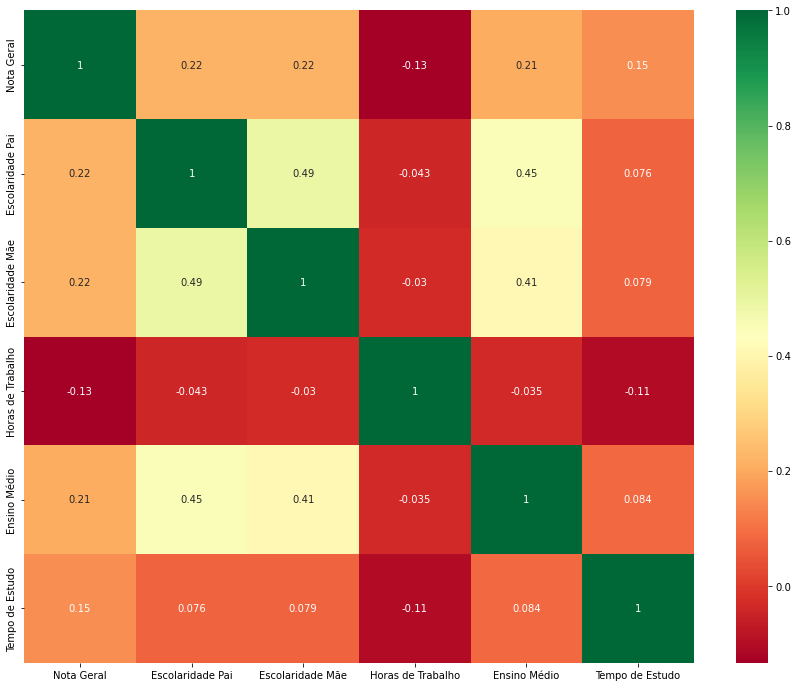

In [34]:
plt.figure(figsize=(15,12))
sns.heatmap(economia_cor, annot = True, cmap= "RdYlGn");
#plt.title('Correlação de Pearson',size=15);
#plt.Axes(size=15);

In [35]:
economia_var.dropna(inplace=True)

## Regressões

In [36]:
dummies.columns

Index(['Nota Geral', 'Escolaridade Pai_0.0', 'Escolaridade Pai_1.0',
       'Escolaridade Mãe_0.0', 'Escolaridade Mãe_1.0', 'Tempo de Estudo_0.0',
       'Tempo de Estudo_1.0', 'Tempo de Estudo_2.0', 'Tempo de Estudo_3.0',
       'Tempo de Estudo_4.0', 'Horas de Trabalho_0.0', 'Horas de Trabalho_1.0',
       'Horas de Trabalho_2.0', 'Horas de Trabalho_3.0',
       'Horas de Trabalho_4.0', 'Ensino Médio_0.0', 'Ensino Médio_1.0'],
      dtype='object')

## Regressão Mútipla

### Regressão Múltipla com OLS

In [37]:
X = dummies[['Escolaridade Pai_1.0',
       'Escolaridade Mãe_1.0',
       'Tempo de Estudo_1.0', 'Tempo de Estudo_2.0', 'Tempo de Estudo_3.0',
       'Tempo de Estudo_4.0', 'Horas de Trabalho_1.0',
       'Horas de Trabalho_2.0', 'Horas de Trabalho_3.0',
       'Horas de Trabalho_4.0', 'Ensino Médio_1.0']] 
Y = dummies['Nota Geral']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

model_OLS = (sm.OLS(Y,sm.add_constant(X)).fit())
#predictions = model.predict(X) 
 
print_model = model_OLS.summary()
print(print_model)

Intercept: 
 35.805243609325984
Coefficients: 
 [ 2.91853039  3.19820749 -0.50777371  1.07313683  3.17284552  4.43874181
 -1.08318903 -1.9146077  -1.76986864 -3.10078367  2.70467162]
                            OLS Regression Results                            
Dep. Variable:             Nota Geral   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     83.35
Date:                Sun, 26 Jun 2022   Prob (F-statistic):          3.11e-179
Time:                        12:50:32   Log-Likelihood:                -31812.
No. Observations:                8073   AIC:                         6.365e+04
Df Residuals:                    8061   BIC:                         6.373e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           

### Regressão Múltipla com WLS

In [38]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

model_WLS = (sm.WLS(Y,sm.add_constant(X), weights=list(range(1, len(Y)+1))).fit())
#predictions = model.predict(X) 
 
print_model = model_WLS.summary()
print(print_model)

Intercept: 
 35.805243609325984
Coefficients: 
 [ 2.91853039  3.19820749 -0.50777371  1.07313683  3.17284552  4.43874181
 -1.08318903 -1.9146077  -1.76986864 -3.10078367  2.70467162]
                            WLS Regression Results                            
Dep. Variable:             Nota Geral   R-squared:                       0.106
Model:                            WLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     86.84
Date:                Sun, 26 Jun 2022   Prob (F-statistic):          1.25e-186
Time:                        12:50:32   Log-Likelihood:                -33040.
No. Observations:                8073   AIC:                         6.610e+04
Df Residuals:                    8061   BIC:                         6.619e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           

### Regressão Múltipla com GLS

In [39]:
y_reshape = np.array(Y).reshape(-1,1)
x_reshape = np.array(X)

In [40]:
X.shape[0]

8073

In [41]:
ols_resid =  (sm.OLS(y_reshape,x_reshape).fit().resid)
res_fit = sm.OLS(ols_resid[1:], ols_resid[:-1]).fit()
rho = res_fit.params

from scipy.linalg import toeplitz
order = toeplitz(np.arange(16))
sigma = rho**order

In [42]:
#GLS Regression fitting
resid=sm.OLS(np.log(list(model_OLS.resid**2)),X).fit()
sigma=np.zeros((X.shape[0],X.shape[0]))
##we estimate the sigma matrix to weight our regression model.
##this process is a feasible way to alleviate the heteroscedastic problem.
np.fill_diagonal(sigma,1/(np.exp(resid.predict(X))**0.5))


In [43]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

model_GLS = (sm.GLS(Y,sm.add_constant(X), sigma=sigma).fit())
#predictions = model.predict(X) 
 
print_model = model_GLS.summary()
print(print_model)

Intercept: 
 35.805243609325984
Coefficients: 
 [ 2.91853039  3.19820749 -0.50777371  1.07313683  3.17284552  4.43874181
 -1.08318903 -1.9146077  -1.76986864 -3.10078367  2.70467162]
                            GLS Regression Results                            
Dep. Variable:             Nota Geral   R-squared:                       0.112
Model:                            GLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     92.27
Date:                Sun, 26 Jun 2022   Prob (F-statistic):          4.48e-198
Time:                        12:51:09   Log-Likelihood:                -32295.
No. Observations:                8073   AIC:                         6.461e+04
Df Residuals:                    8061   BIC:                         6.470e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           

## Testes de Heterocedasticidade

### Teste Goldfeld

#### OLS

In [44]:
nomes = ['Estatística F','p-valor','Situação da variância']
testeh = het_goldfeldquandt(model_OLS.resid, model_OLS.model.exog)
lzip(nomes, testeh)

[('Estatística F', 0.9545660816719898),
 ('p-valor', 0.9298593359741754),
 ('Situação da variância', 'increasing')]

#### WLS

In [45]:
nomes = ['Estatística F','p-valor','Situação da variância']
testeh = het_goldfeldquandt(model_WLS.resid, model_WLS.model.exog)
lzip(nomes, testeh)

[('Estatística F', 0.9545660816719898),
 ('p-valor', 0.9298593359741754),
 ('Situação da variância', 'increasing')]

#### GLS

In [46]:
nomes = ['Estatística F','p-valor','Situação da variância']
testeh = het_goldfeldquandt(model_GLS.resid, model_GLS.model.exog)
lzip(nomes, testeh)

[('Estatística F', 0.9545660816719898),
 ('p-valor', 0.9298593359741754),
 ('Situação da variância', 'increasing')]

## Teste Breusch Pagan

#### OLS

In [47]:
nomes = ['Estatística Multiplicador de Lagrange','p-valor','Estatística F','f p-valor']
for i,j in zip(nomes,het_breuschpagan(model_OLS.resid, model_OLS.model.exog)):
    print(i,':',j)

Estatística Multiplicador de Lagrange : 97.38995109956575
p-valor : 5.861662024011792e-16
Estatística F : 8.948422309336058
f p-valor : 4.666796227773734e-16


#### WLS

In [48]:
nomes = ['Estatística Multiplicador de Lagrange','p-valor','Estatística F','f p-valor']
for i,j in zip(nomes,het_breuschpagan(model_WLS.resid, model_WLS.model.exog)):
    print(i,':',j)

Estatística Multiplicador de Lagrange : 99.44583506763789
p-valor : 2.299036289019835e-16
Estatística F : 9.13967780693884
f p-valor : 1.8101121455246073e-16


#### GLS

In [49]:
nomes = ['Estatística Multiplicador de Lagrange','p-valor','Estatística F','f p-valor']
for i,j in zip(nomes,het_breuschpagan(model_GLS.resid, model_GLS.model.exog)):
    print(i,':',j)

Estatística Multiplicador de Lagrange : 96.58252410346498
p-valor : 8.461235360798569e-16
Estatística F : 8.873335670153958
f p-valor : 6.765505771906758e-16


## Teste White

### OLS

In [50]:
nomes = ['Estatística Multiplicador de Lagrange','p-valor','Estatística F','f p-valor']
for i,j in zip(nomes,het_white(model_OLS.resid, model_OLS.model.exog)):
    print(i,':',j)

Estatística Multiplicador de Lagrange : 148.43946201243432
p-valor : 9.493053430925869e-11
Estatística F : 2.7812912936011855
f p-valor : 7.196666568348416e-11


### WLS

In [51]:
nomes = ['Estatística Multiplicador de Lagrange','p-valor','Estatística F','f p-valor']
for i,j in zip(nomes,het_white(model_WLS.resid, model_WLS.model.exog)):
    print(i,':',j)

Estatística Multiplicador de Lagrange : 151.23948895718507
p-valor : 3.769890260496205e-11
Estatística F : 2.8347566614215713
f p-valor : 2.810420847528279e-11


### GLS

In [52]:
nomes = ['Estatística Multiplicador de Lagrange','p-valor','Estatística F','f p-valor']
for i,j in zip(nomes,het_white(model_GLS.resid, model_GLS.model.exog)):
    print(i,':',j)

Estatística Multiplicador de Lagrange : 147.1247954860735
p-valor : 1.460183251891306e-10
Estatística F : 2.7562013068273994
f p-valor : 1.1155199488092625e-10


## Gráficos

In [53]:
economia_var

,Nota Geral,Escolaridade Pai,Escolaridade Mãe,Horas de Trabalho,Ensino Médio,Tempo de Estudo
160,24.9,0.0,0.0,4.0,0.0,2.0
161,25.6,0.0,0.0,4.0,0.0,1.0
162,48.7,0.0,0.0,4.0,0.0,2.0
163,35.7,0.0,0.0,4.0,0.0,1.0
164,33.9,0.0,0.0,4.0,1.0,2.0
...,...,...,...,...,...,...
546659,40.9,1.0,1.0,4.0,0.0,1.0
547633,32.2,0.0,1.0,0.0,1.0,1.0
547634,27.8,1.0,0.0,2.0,0.0,3.0
547635,30.2,0.0,0.0,3.0,0.0,1.0


In [54]:
economia_var['residuos'] = model_WLS.resid

<AxesSubplot:xlabel='Nota Geral', ylabel='residuos'>

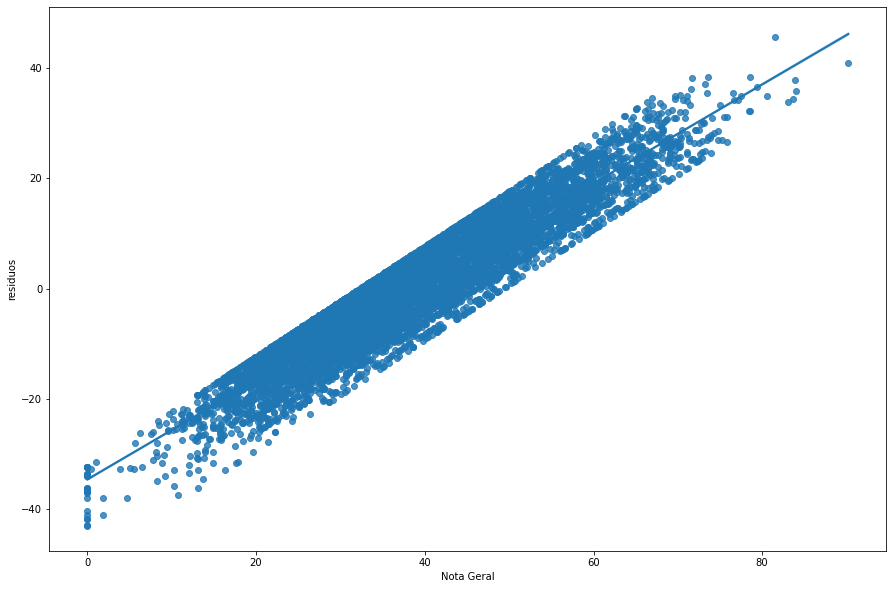

In [55]:
fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x='Nota Geral',y='residuos',data=economia_var)

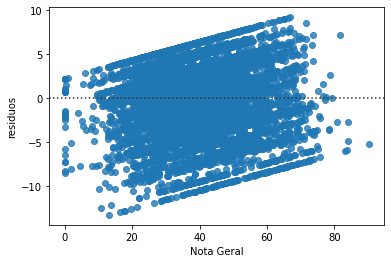

In [56]:
sns.residplot(x='Nota Geral', y='residuos', data=economia_var)
  
plt.show()

### Comparação de Coeficientes 

In [57]:
model_OLS.params.index

Index(['const', 'Escolaridade Pai_1.0', 'Escolaridade Mãe_1.0',
       'Tempo de Estudo_1.0', 'Tempo de Estudo_2.0', 'Tempo de Estudo_3.0',
       'Tempo de Estudo_4.0', 'Horas de Trabalho_1.0', 'Horas de Trabalho_2.0',
       'Horas de Trabalho_3.0', 'Horas de Trabalho_4.0', 'Ensino Médio_1.0'],
      dtype='object')

In [58]:
#Compare OSL and GSL coefficients
x=[]
for i in model_OLS.pvalues:
    if i<0.01: x.append("***")
    else: 
        if i<0.05: x.append("**")
        else: 
            if i <0.1: x.append("*")
            else: x.append("insignificant")
y=[]
for i in model_WLS.pvalues:
    if i<0.01: y.append("***")
    else: 
        if i<0.05: y.append("**")
        else: 
            if i <0.1: y.append("*")
            else: y.append("insignificant")
z=[]
for i in model_GLS.pvalues:
    if i<0.01: z.append("***")
    else: 
        if i<0.05: z.append("**")
        else: 
            if i <0.1: z.append("*")
            else: z.append("insignificant")
            
pd.DataFrame({"OLS":list(model_OLS.params),"WLS":list(model_WLS.params),"GLS":list(model_GLS.params),"ols_pvalue":x,"wls_pvalue":y,"gls_pvalue":z},index=model_OLS.params.index)
##GLS will tend to suppress insignificant coefficients and elevate significant ones.


,OLS,WLS,GLS,ols_pvalue,wls_pvalue,gls_pvalue
const,35.805244,36.174234,35.435991,***,***,***
Escolaridade Pai_1.0,2.918530,2.874180,3.020261,***,***,***
Escolaridade Mãe_1.0,3.198207,3.505982,3.167370,***,***,***
Tempo de Estudo_1.0,-0.507774,-1.034630,-0.218954,insignificant,**,insignificant
Tempo de Estudo_2.0,1.073137,0.526186,1.370110,**,insignificant,insignificant
Tempo de Estudo_3.0,3.172846,2.685300,3.611171,***,***,***
Tempo de Estudo_4.0,4.438742,3.710113,4.750338,***,***,***
Horas de Trabalho_1.0,-1.083189,-1.382665,-0.917382,insignificant,*,insignificant
Horas de Trabalho_2.0,-1.914608,-1.954902,-1.871805,***,***,***
Horas de Trabalho_3.0,-1.769869,-1.598497,-1.842513,***,***,***
